# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [16]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

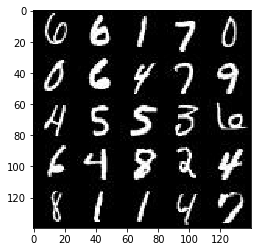

In [17]:
show_n_images = 25


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

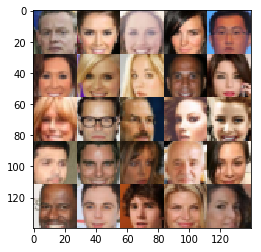

In [18]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [20]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z  = tf.placeholder(tf.float32, (None, z_dim), name = 'input_z')
    learn_rate = tf.placeholder(tf.float32, shape=[])
    return inputs_real, inputs_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [21]:
def discriminator(images, reuse=False, alpha = 0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse = reuse):
        x1 = tf.layers.conv2d(images,64, 5, strides = 2, padding = 'same')
        relu1 = tf.maximum(alpha*x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides = 2, padding = 'same')
        bn2 = tf.layers.batch_normalization(x2, training = True)
        relu2 = tf.maximum(alpha*bn2,bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides = 2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training= True)
        relu3 = tf.maximum(alpha*bn3, bn3)
        
        flat = tf.reshape(relu3, (-1,4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [23]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    keep_prob=0.5
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*1024)
        
        # Reshape it to start the convolutional stack     
        x1 = tf.reshape(x1, (-1, 7, 7, 1024))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, keep_prob=keep_prob)
        # 7x7x1024 now

        x2 = tf.layers.conv2d_transpose(x1, 512, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        # 14x14x512 now
        
        x3 = tf.layers.conv2d_transpose(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        # 28x28x256 now

        # Use strides=1 to preserve 28x28
        x4 = tf.layers.conv2d_transpose(x3, 128, 5, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        x4 = tf.nn.dropout(x4, keep_prob=keep_prob)  
        # 28x28x128 now        
        
        # Output layer
        # Use strides=1 to preserve 28x28
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)    

    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [24]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.2 
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake) * (1 - smooth)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [25]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # TODO: Implement Function

    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)    
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [26]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [27]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, l_r = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, l_r, beta1)
    d_loss_vec = []
    g_loss_vec = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2 # Scale from [-0.5, 0.5] to [-1, 1]
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))      

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, l_r: learning_rate})

                # Optimize twice for generator so discriminator loss does not go to 0
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, l_r: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, l_r: learning_rate})

                # Store losses every 10 steps for plotting
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})   
                    d_loss_vec.append(train_loss_d)
                    g_loss_vec.append(train_loss_g)

                # Display loss and generator output every 100 steps
                if steps % 100 == 0:                        
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 1.8471... Generator Loss: 0.5753


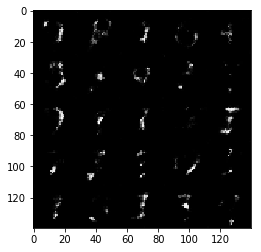

Epoch 1/2... Discriminator Loss: 1.6768... Generator Loss: 0.4889


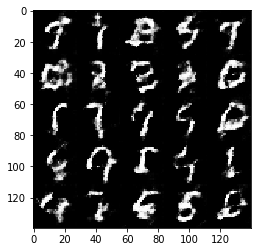

Epoch 1/2... Discriminator Loss: 1.4483... Generator Loss: 0.8351


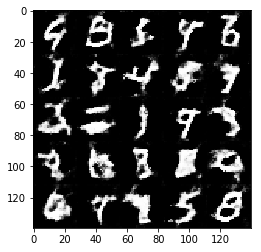

Epoch 1/2... Discriminator Loss: 1.6323... Generator Loss: 0.5284


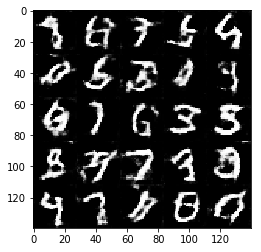

Epoch 1/2... Discriminator Loss: 1.5343... Generator Loss: 0.6572


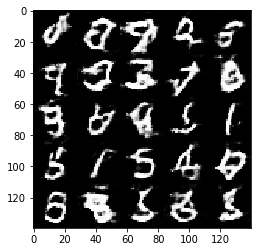

Epoch 1/2... Discriminator Loss: 2.0290... Generator Loss: 0.2888


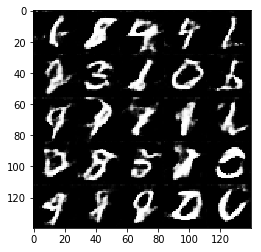

Epoch 1/2... Discriminator Loss: 1.6175... Generator Loss: 0.4845


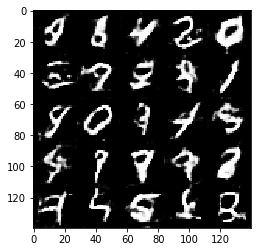

Epoch 1/2... Discriminator Loss: 1.6009... Generator Loss: 0.5104


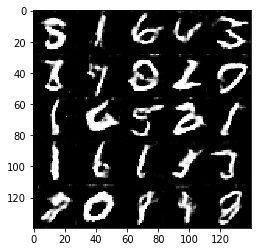

Epoch 1/2... Discriminator Loss: 1.6720... Generator Loss: 1.4527


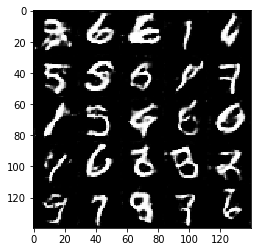

Epoch 1/2... Discriminator Loss: 1.7895... Generator Loss: 0.4422


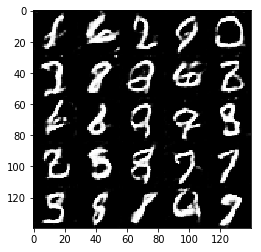

Epoch 1/2... Discriminator Loss: 1.4498... Generator Loss: 0.6302


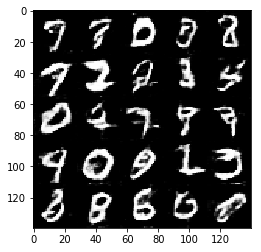

Epoch 1/2... Discriminator Loss: 1.1938... Generator Loss: 1.0049


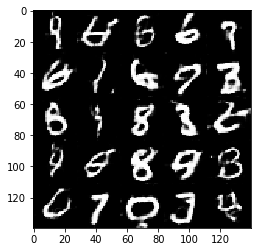

Epoch 1/2... Discriminator Loss: 1.2642... Generator Loss: 1.1617


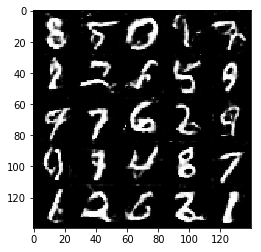

Epoch 1/2... Discriminator Loss: 1.6547... Generator Loss: 0.5110


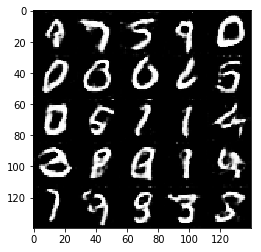

Epoch 1/2... Discriminator Loss: 1.4272... Generator Loss: 0.6948


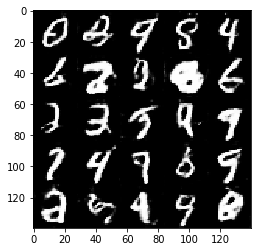

Epoch 1/2... Discriminator Loss: 1.1549... Generator Loss: 0.8894


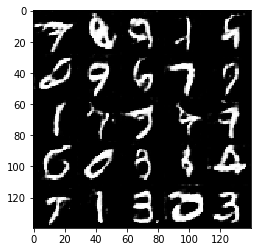

Epoch 1/2... Discriminator Loss: 1.1497... Generator Loss: 0.7455


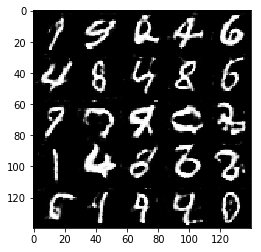

Epoch 1/2... Discriminator Loss: 1.1269... Generator Loss: 0.9037


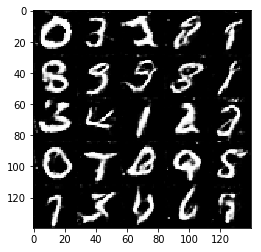

Epoch 2/2... Discriminator Loss: 1.3222... Generator Loss: 0.7090


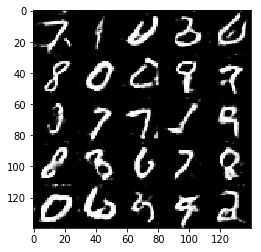

Epoch 2/2... Discriminator Loss: 1.1429... Generator Loss: 1.1160


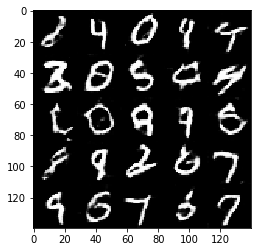

Epoch 2/2... Discriminator Loss: 1.4152... Generator Loss: 0.5755


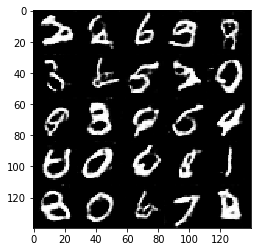

Epoch 2/2... Discriminator Loss: 1.3066... Generator Loss: 0.5953


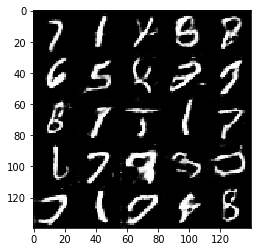

Epoch 2/2... Discriminator Loss: 1.2528... Generator Loss: 0.6917


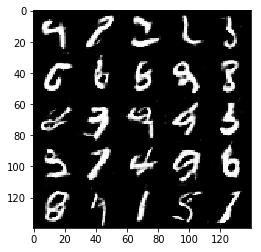

Epoch 2/2... Discriminator Loss: 1.2560... Generator Loss: 1.0030


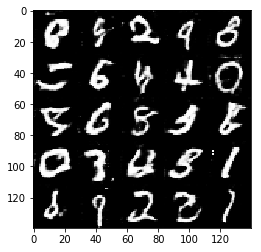

Epoch 2/2... Discriminator Loss: 1.2217... Generator Loss: 1.0742


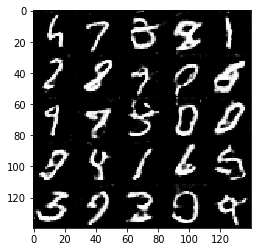

Epoch 2/2... Discriminator Loss: 1.2872... Generator Loss: 0.7967


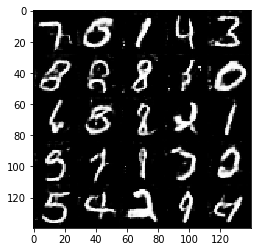

Epoch 2/2... Discriminator Loss: 1.0347... Generator Loss: 1.5695


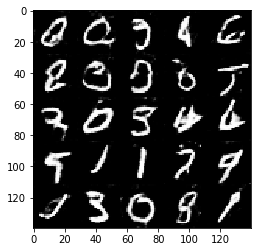

Epoch 2/2... Discriminator Loss: 1.6021... Generator Loss: 0.5147


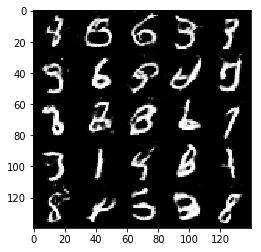

Epoch 2/2... Discriminator Loss: 0.9826... Generator Loss: 0.9895


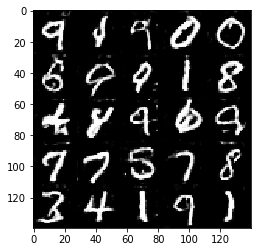

Epoch 2/2... Discriminator Loss: 0.9598... Generator Loss: 1.2598


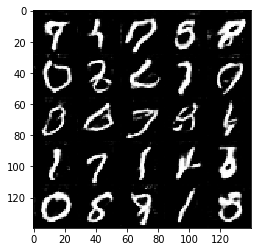

Epoch 2/2... Discriminator Loss: 1.2309... Generator Loss: 1.1132


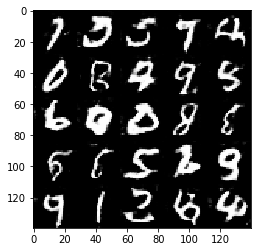

Epoch 2/2... Discriminator Loss: 0.9042... Generator Loss: 1.5393


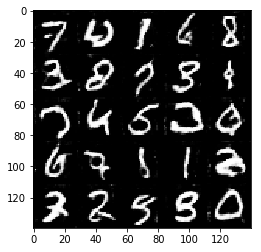

Epoch 2/2... Discriminator Loss: 0.9918... Generator Loss: 1.3611


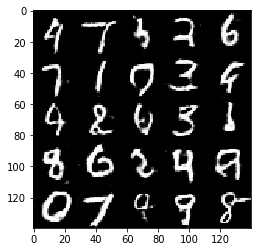

Epoch 2/2... Discriminator Loss: 0.9187... Generator Loss: 1.3112


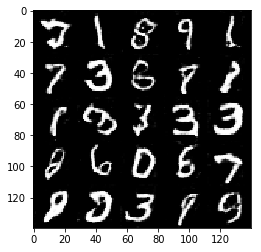

Epoch 2/2... Discriminator Loss: 1.0566... Generator Loss: 1.0371


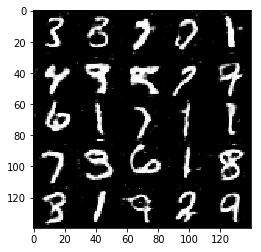

Epoch 2/2... Discriminator Loss: 0.8657... Generator Loss: 1.5768


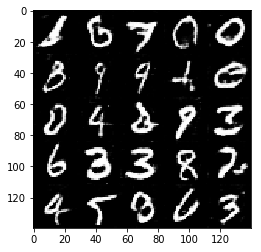

Epoch 2/2... Discriminator Loss: 1.3720... Generator Loss: 0.9738


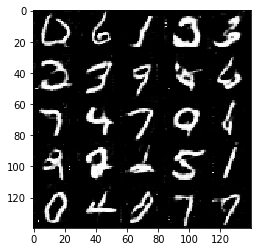

In [28]:
batch_size = 32 
z_dim = 256 
learning_rate = 0.0008 # between 0.0002 and 0.0008
beta1 = 0.4 # between 0.2 and 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 1.0021... Generator Loss: 1.2706


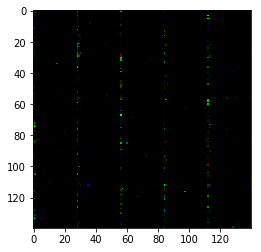

Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 1.8281


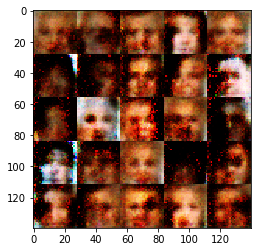

Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 0.8478


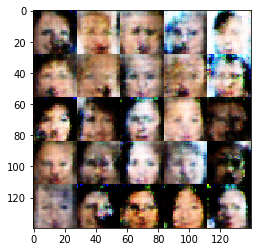

Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 0.6402


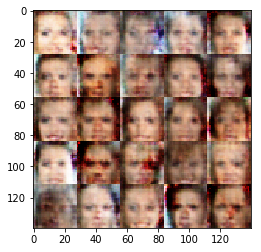

Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.9153


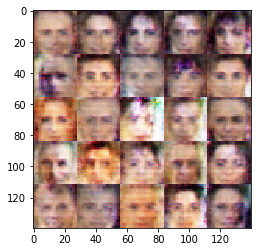

Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.7653


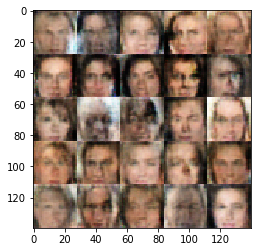

Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 0.8190


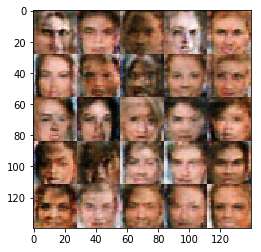

Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.7912


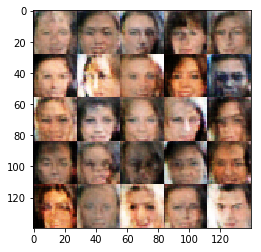

Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.7607


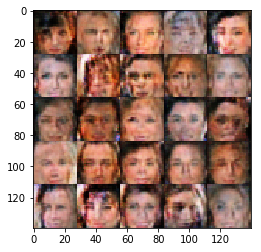

Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.7780


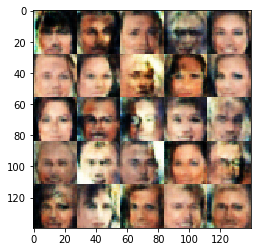

Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.8069


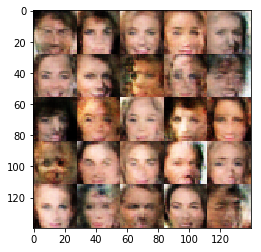

Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.7490


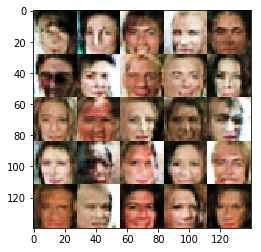

Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.7724


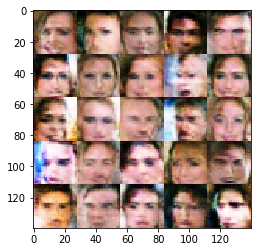

Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.7875


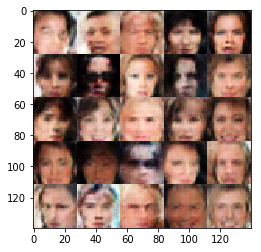

Epoch 1/1... Discriminator Loss: 1.4786... Generator Loss: 0.6987


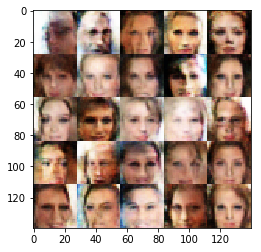

Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.8036


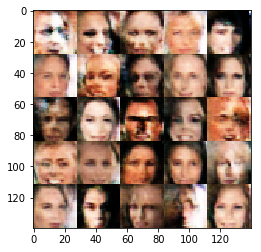

Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.7485


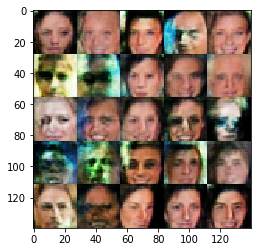

Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.8721


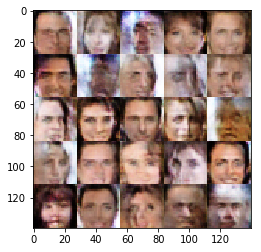

Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.8973


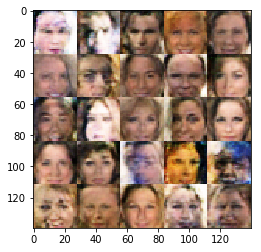

Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.8634


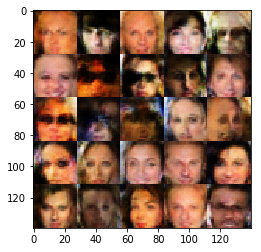

Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.7768


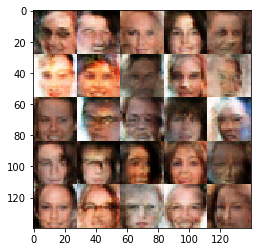

Epoch 1/1... Discriminator Loss: 1.4894... Generator Loss: 0.7846


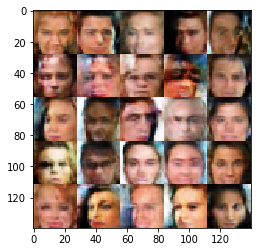

Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.7999


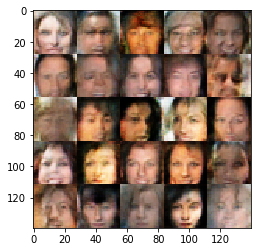

Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.8136


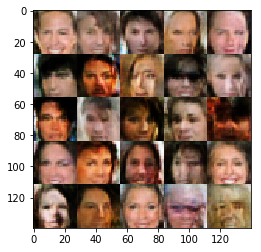

Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.7824


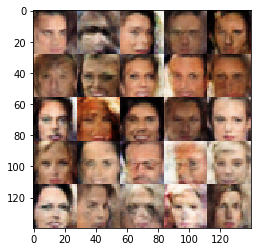

Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 0.7247


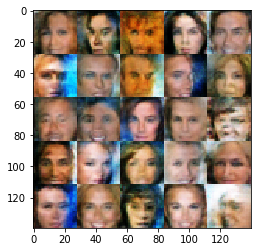

Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.6956


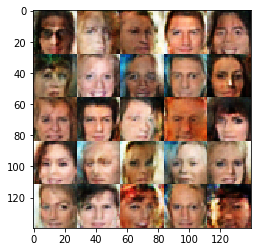

Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.7929


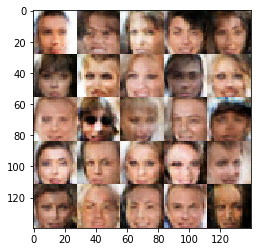

Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.9219


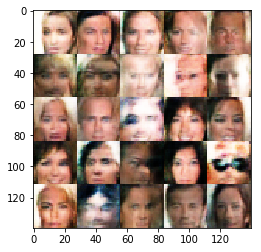

Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.8563


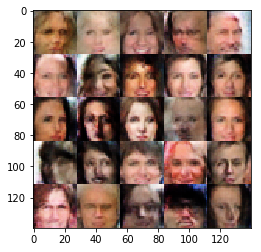

Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.8024


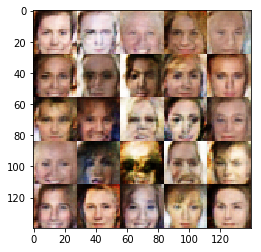

Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.9193


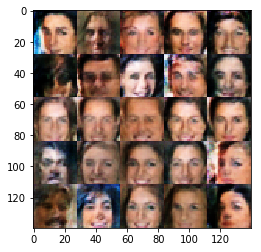

Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.8727


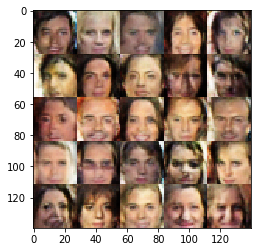

Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.8432


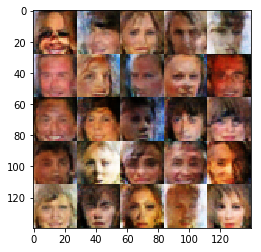

Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7882


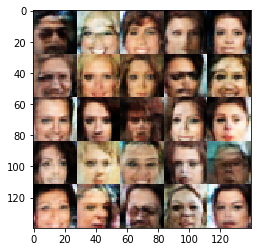

Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.7412


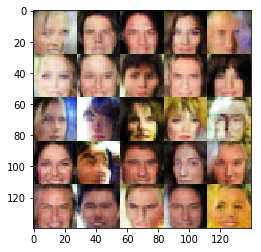

Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.8268


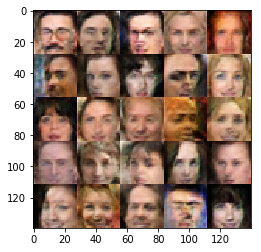

Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.8494


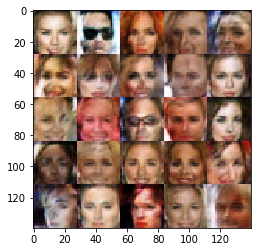

Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.8567


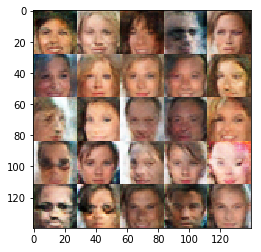

Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.8320


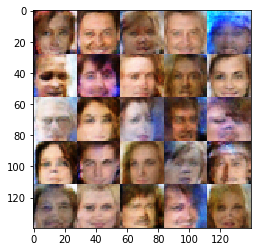

Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.8342


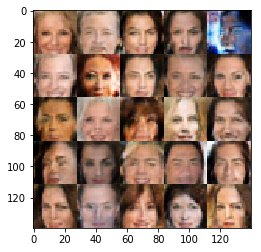

Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.7759


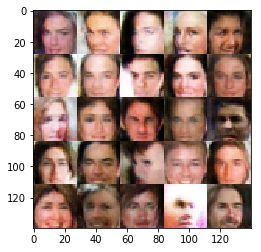

Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.7638


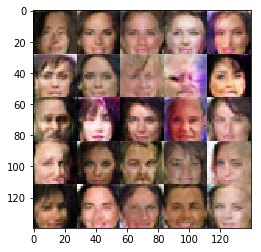

Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.8072


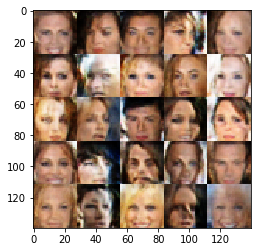

Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.8869


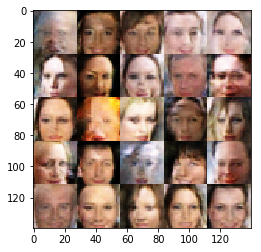

Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.7755


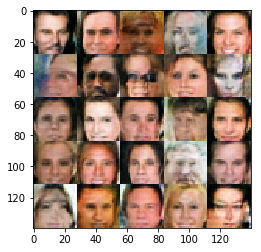

Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.8096


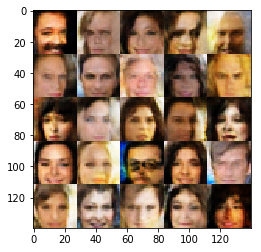

Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.8332


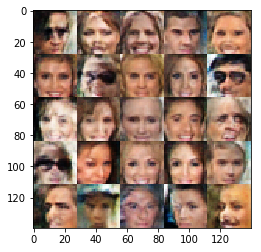

Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.7858


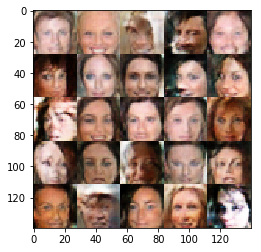

Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.7585


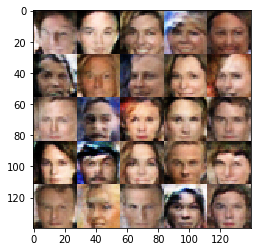

Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.9155


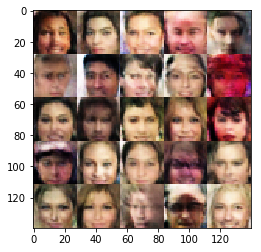

Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.8910


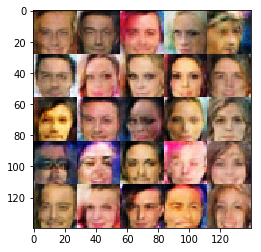

In [ ]:
batch_size = 32 # start experimenting between 16 and 32
z_dim = 128 # 128 - 256
learning_rate = 0.0003 # between 0.0002 and 0.0008
beta1 = 0.4 # between 0.2 and 0.5



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。